
    0: bite
    1: chew
    2: chew-bite


In [1]:
# Beat tracking example
from __future__ import print_function
import librosa
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.fftpack import fft
import pandas as pd
import numpy as np
import os
import time
from scipy.io import wavfile as wv
from scipy import signal
import pywt

In [71]:
from sklearn.preprocessing import normalize

In [2]:
import seaborn as sns

#### Functions

In [3]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [4]:
def lowpass(signal, sample_freq, cutoff_freq):
    # Low-pass filtering 
    norm_cutoff_freq = cutoff_freq / (sample_freq / 2.0)
    b, a = signal.butter(2, norm_cutoff_freq, 'low')
    return signal.filtfilt(b, a, y, axis=0)

In [5]:
class WaveDataset():
    def __init__(self, data_folder, annotation_file):
        self.data_folder = data_folder
        ds = pd.read_csv(annotation_file)
        self.filenames = list(ds['filename'])
        if 'label' in ds.columns:
            self.labels = list(ds['label'])
        else:
            self.labels = [-1 for i in range(len(self.filenames))]
        self.cache = {}
        
    def __len__(self):
        return(len(self.labels))

    def __getitem__(self, index):
        if index in self.cache:
            data, label = self.cache[index]
        else:
            fname = os.path.join(self.data_folder, "%04d.wav" % self.filenames[index])
            _, data = wv.read(fname)
            label = self.labels[index]
            self.cache[index] = (data, label)
        return data, label

In [6]:
def discrete_wavelet(raw_signal, waveletname = 'sym5', levels = 5):
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal: ")
    ax.plot(raw_signal)
    plt.show()


    fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(6,6))
    for ii in range(levels):
        (data, coeff_d) = pywt.dwt(raw_signal, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()
    pass

In [7]:
def plot_wavelet(time, signal, scales, waveletname = 'cmor'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    # Show w.r.t. time and frequency
    plt.figure(figsize=(5, 2))
    plt.pcolor(time, frequencies, coefficients)

    # Set yscale, ylim and labels
    plt.yscale('log')
    plt.ylim([1, 100])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    #plt.savefig('egg.png', dpi=150)
    
    pass

In [17]:
def preprocessing(raw_signal):

    # Rectification 
    rectified_signal = np.abs(raw_signal)

    # Low-pass filtering -> envelope
    sample_freq = 22050 # Hz
    cutoff_freq = 5     # Hz
    norm_cutoff_freq = cutoff_freq / (sample_freq / 2.0)
    b, a = signal.butter(2, norm_cutoff_freq, 'low')
    envelope = signal.filtfilt(b, a, rectified_signal, axis=0)

    return envelope, rectified_signal

In [235]:
def extract_features(raw_signal, plot_features=False):
    
    envelope, rectified_signal = preprocessing(raw_signal)
    print(np.mean(envelope))
    threshold = 0.0115 * (2 ** 16) # to compute duration and envelope slope sign
    above_thres = envelope >= threshold  # samples to consider in computation
    
    max_pos = np.argmax(envelope)
    envelope_slope_sign = np.sign(np.diff(envelope, append=0)) * above_thres    
    duration_signal = np.ones(envelope.shape) * above_thres

    # features
    duration = np.sum(duration_signal)
    
    if duration == 0:
        threshold = np.mean(envelope)
        above_thres = envelope >= threshold  # samples to consider in computation
        envelope_slope_sign = np.sign(np.diff(envelope, append=0)) * above_thres    
        duration_signal = np.ones(envelope.shape) * above_thres
        duration = np.sum(duration_signal)
        
    zero_crossing = np.count_nonzero(np.abs(np.diff(envelope_slope_sign)))
    amplitude = max(rectified_signal)
    ratio = np.trapz(envelope[:max_pos], axis=0) / np.trapz(envelope, axis=0)

    features = [duration, zero_crossing, float(amplitude), float(ratio), duration_signal]  
    
    # Illustrate features
    if plot_features:
        #print(features)
        fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8,6), sharex=True)
        axes[0].plot(raw_signal); axes[0].set_title("Señal sonora")
        axes[1].plot(envelope); axes[1].set_title("Envolvente")
        axes[2].plot(envelope_slope_sign); axes[2].set_title("Signo de la pendiente de la envolvente")
        axes[3].plot(duration_signal); axes[3].set_title("Duración")
        axes[3].set_xlabel("muestras")
        fig.tight_layout()
    
    return features

### Load data

In [8]:
train_labels = pd.read_csv('data/raw/train_labels.csv')

#### Categorias

In [9]:
category_group = train_labels.groupby('label').size().reset_index()
category_group.columns = ['label','counts']

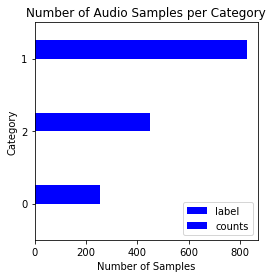

In [10]:
plot = category_group.sort_values(ascending=True, by='counts').plot(
    kind='barh', 
    title="Number of Audio Samples per Category", 
    color='blue', 
    figsize=(4,4))
plot.set_xlabel("Number of Samples")
plot.set_ylabel("Category");

In [11]:
category_group 

,label,counts
0,0,255
1,1,827
2,2,450


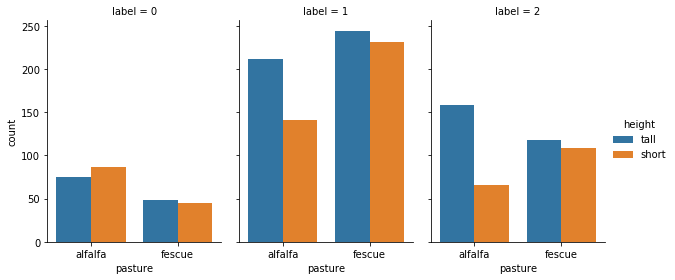

In [12]:
g = sns.catplot(x="pasture", hue="height", col="label",
                data=train_labels, kind="count",
                    height=4, aspect=.7);
#plt.title("Number of Audio Samples by Category and Pastures ");

## chew-bite

#### raw signal

In [145]:
train_ds = WaveDataset("data/raw/", "data/raw/train_labels.csv")

In [216]:
y = train_ds[0][0]

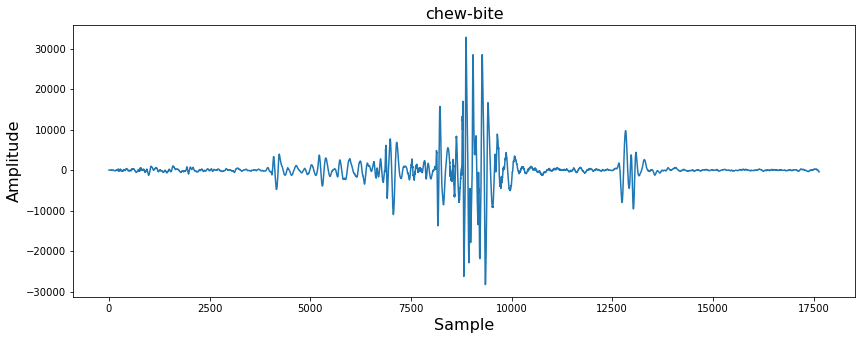

In [217]:
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('chew-bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

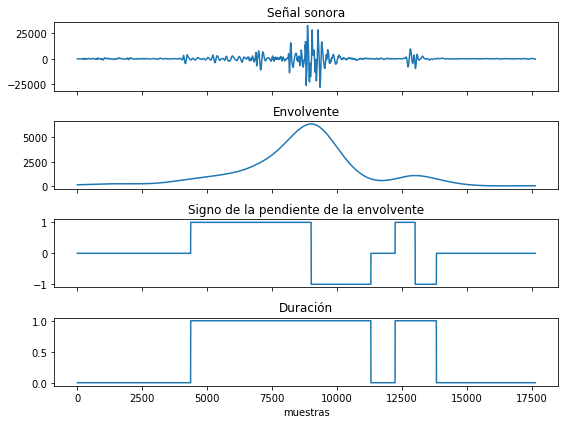

In [218]:
duration, zero_crossing, amplitude, ratio, duration_signal =  extract_features(y, plot_features=True)

In [219]:
itemindex = np.where(duration_signal==1)

y_sliced = y[itemindex]

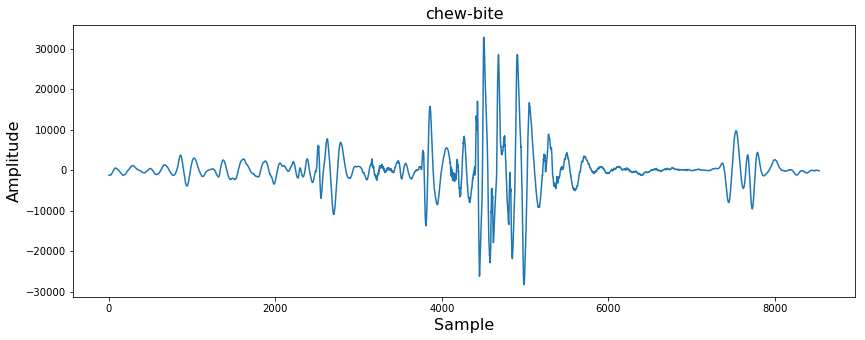

In [220]:
plt.figure(figsize=(14, 5))
plt.plot(y_sliced)
plt.title('chew-bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

#### Fourier

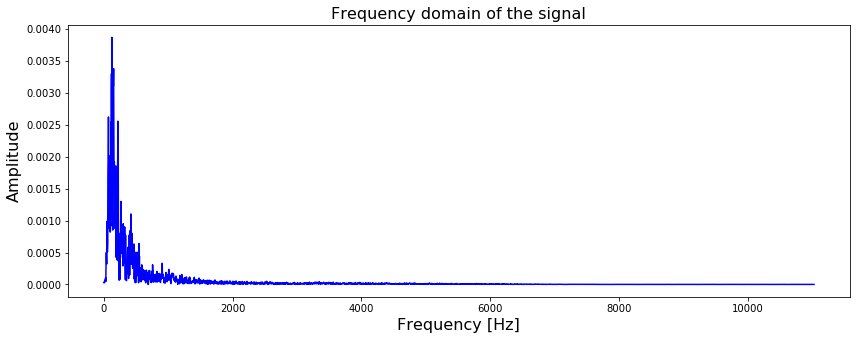

In [214]:
N = len(y_sliced)
T = 1/sr

f_values, fft_values = get_fft_values(normalize(y_sliced.reshape(1,-1))[0], T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

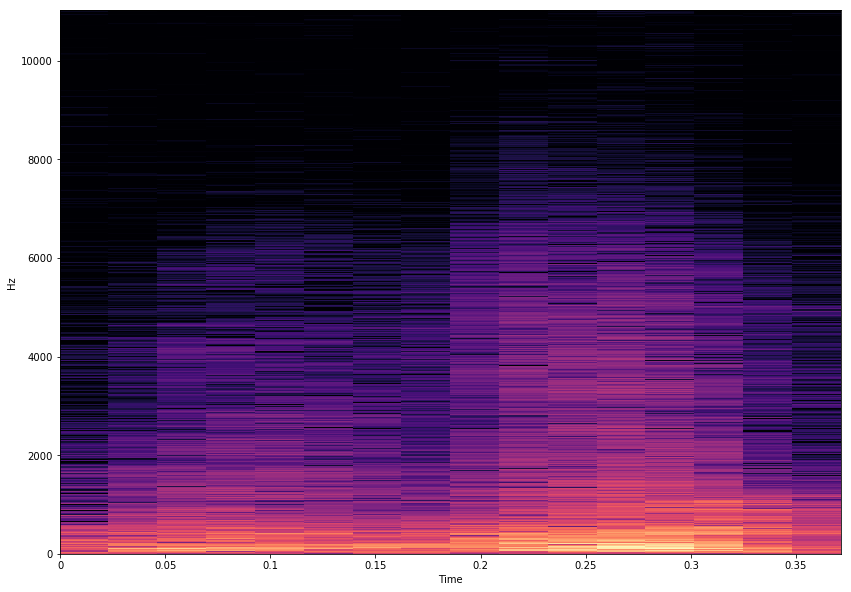

In [215]:
Y = librosa.stft(normalize(y_sliced.reshape(1,-1))[0]) #,  n_fft=512, win_length=512,hop_length=220)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [165]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [166]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=normalize(y_sliced.reshape(1,-1))[0], sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=40)

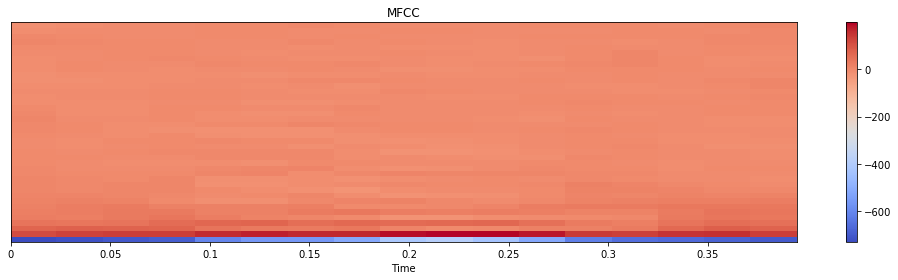

In [167]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

## chew

#### raw signal

In [198]:
y = train_ds[8][0]

In [246]:
y = train_ds[771][0]

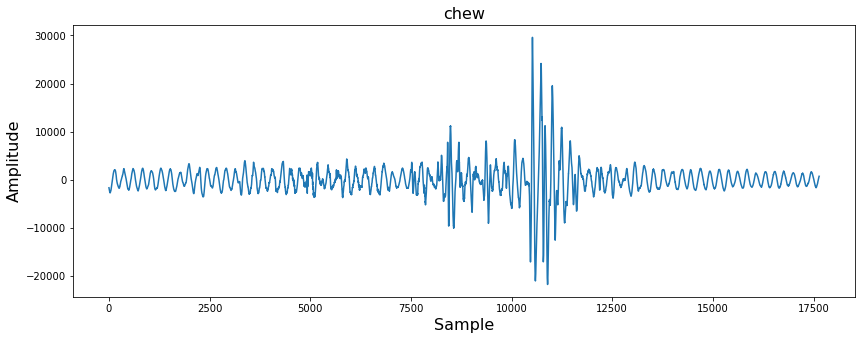

In [247]:
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('chew',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

2041.6952850306834


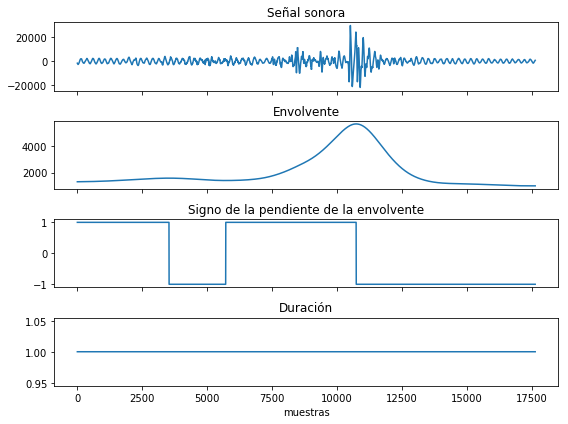

In [248]:
duration, zero_crossing, amplitude, ratio, duration_signal =  extract_features(y, plot_features=True)

In [231]:
itemindex = np.where(duration_signal==1)

y_sliced = y[itemindex]

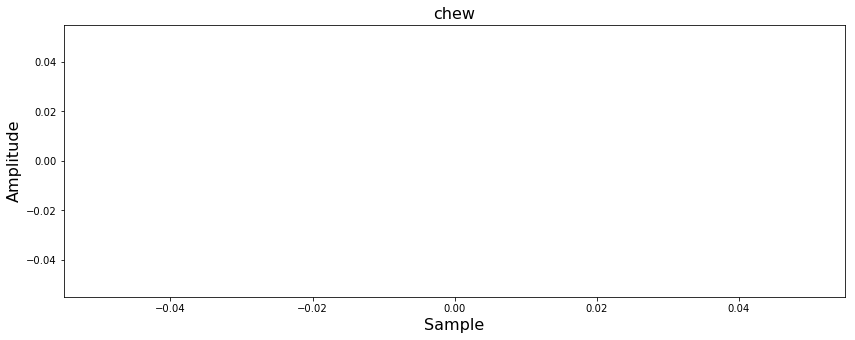

In [232]:
plt.figure(figsize=(14, 5))
plt.plot(y_sliced)
plt.title('chew',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

#### Fourier

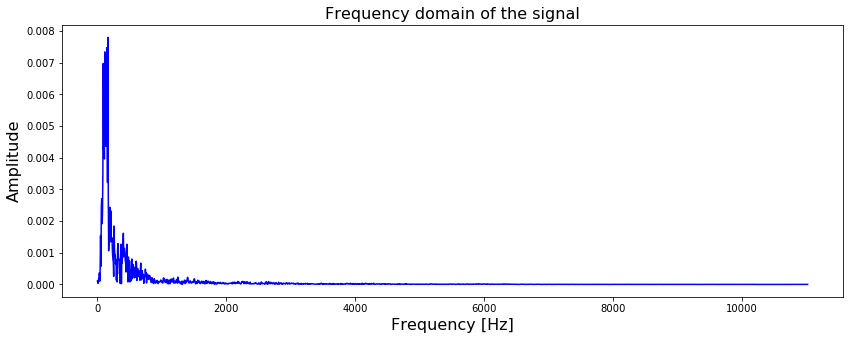

In [203]:
N = len(y_sliced)
T = 1/sr

f_values, fft_values = get_fft_values(normalize(y_sliced.reshape(1,-1))[0], T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

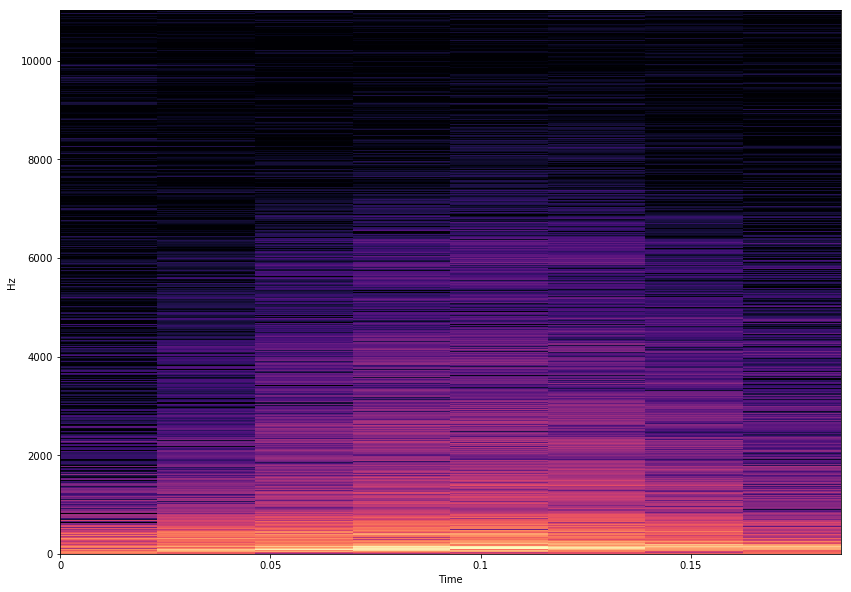

In [204]:
Y = librosa.stft(normalize(y_sliced.reshape(1,-1))[0]) #,  n_fft=512, win_length=512,hop_length=220)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [205]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [206]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=normalize(y_sliced.reshape(1,-1))[0], sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=40)

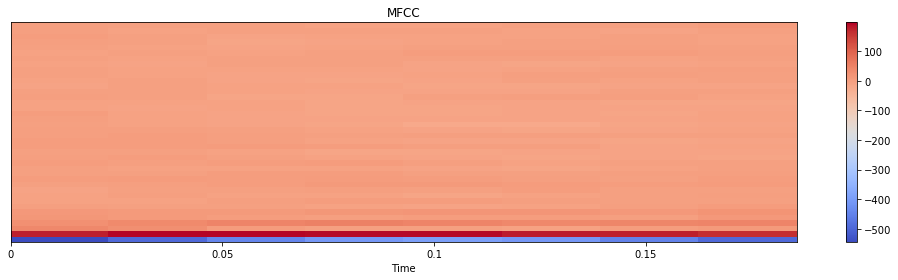

In [207]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

## bite

#### raw signal

In [188]:
y = train_ds[48][0]

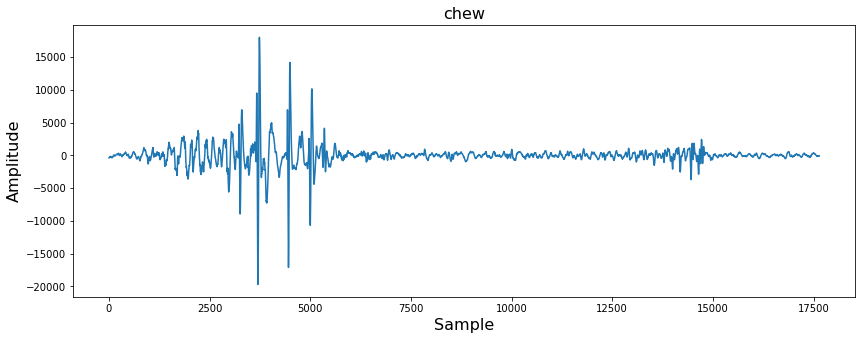

In [189]:
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('chew',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

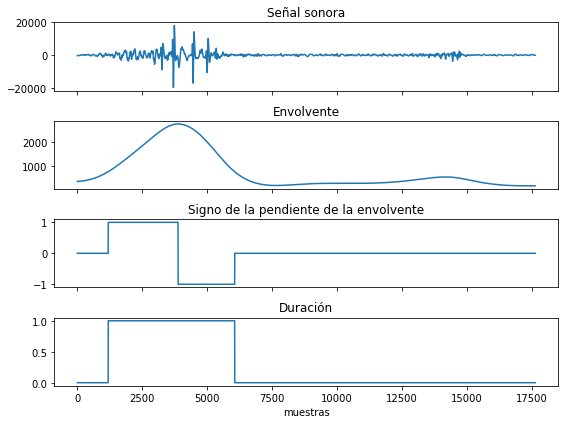

In [190]:
duration, zero_crossing, amplitude, ratio, duration_signal =  extract_features(y, plot_features=True)

In [191]:
itemindex = np.where(duration_signal==1)

y_sliced = y[itemindex]

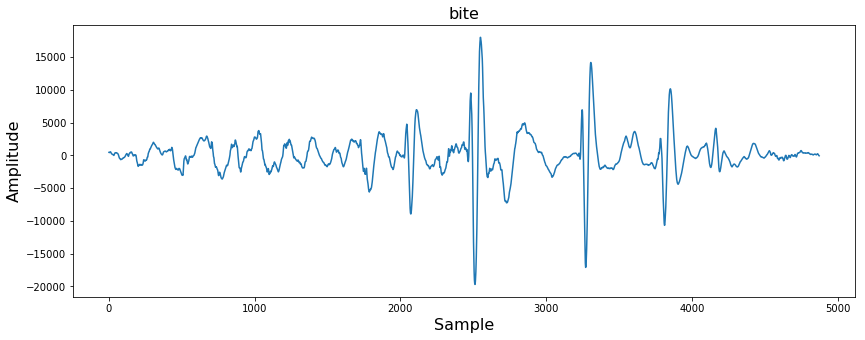

In [192]:
plt.figure(figsize=(14, 5))
plt.plot(y_sliced)
plt.title('bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Sample', fontsize=16)
pass

#### Fourier

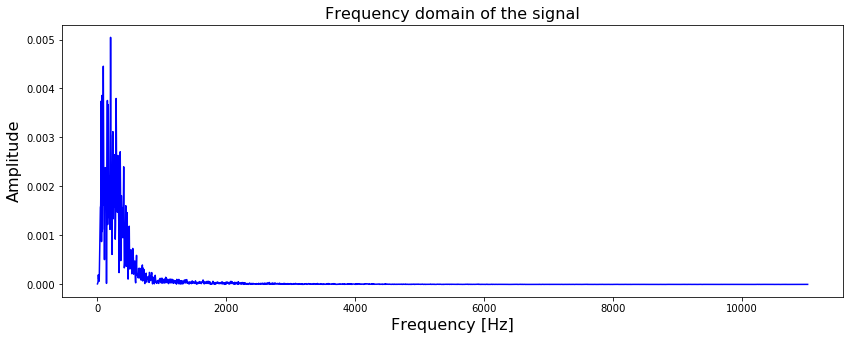

In [193]:
N = len(y_sliced)
T = 1/sr

f_values, fft_values = get_fft_values(normalize(y_sliced.reshape(1,-1))[0], T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

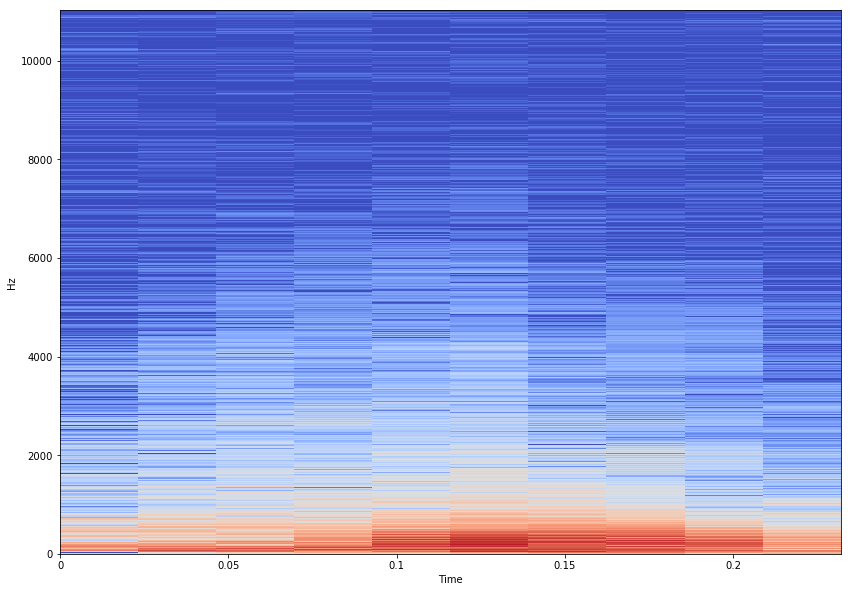

In [194]:
Y = librosa.stft(normalize(y_sliced.reshape(1,-1))[0]) #,  n_fft=512, win_length=512,hop_length=220)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [195]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [196]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=normalize(y_sliced.reshape(1,-1))[0], sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=40)

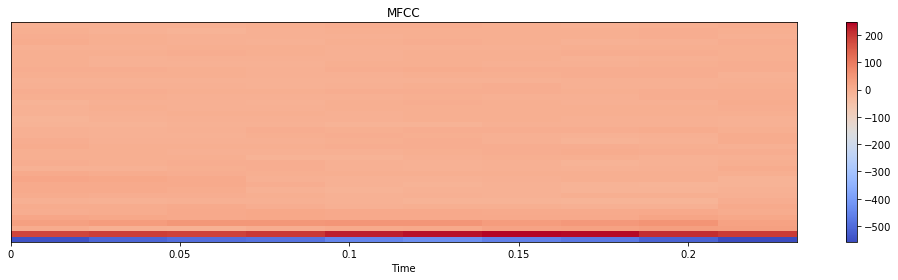

In [197]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()